Read Combined Dataset that we built for Zillow based on Exploratory Analysis result with Values for each Year on  Combination of State and County Name for each of AllHomes, 3 Bed Room, 2 Bed Room, Condo , Percapita Income, Population Growth 

This dataset is input from Exploratory Analysis Result. 

In this process we build Statistical Time Series Models using ARIMA, SARIMA and PROPHET.

In [1]:
import xgboost as xgb
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
dirpath = os.path.join(os.getcwd(), "DS_2025_TeamE\data_files")
# Check if directory exists
if not os.path.exists(dirpath):
    raise FileNotFoundError(f"The directory {dirpath} does not exist.")
else:
    print(f"The directory {dirpath} exists.")
    # List all files in the directory
files_in_dir = os.listdir(dirpath)
print(dirpath)
zhvi_filename = 'zillow_combined_zhvi.csv'
zhvi_filepath = os.path.join(dirpath, zhvi_filename)
zhvi_condo_df = pd.read_csv(zhvi_filepath, header=None)  # Read without headers
zhvi_condo_df.columns = zhvi_condo_df.iloc[0]  # Set first row as column names
zhvi_condo_df = zhvi_condo_df[1:].reset_index(drop=True)  # Remove first row from data
zhvi_condo_fmt_df = zhvi_condo_df.copy()


<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\req92163\AppData\Local\Temp\1\ipykernel_15056\545823798.py:9: SyntaxWarning: invalid escape sequence '\d'
  dirpath = os.path.join(os.getcwd(), "DS_2025_TeamE\data_files")


The directory c:\Users\req92163\OneDrive - Mutual of Omaha\DSCI8950\DS_2025_TeamE\data_files exists.
c:\Users\req92163\OneDrive - Mutual of Omaha\DSCI8950\DS_2025_TeamE\data_files


Convert Deicmal Values to Integers . Replace Nulls with Zeroes.

In [3]:
# Ensure 'Personal_Income_Growth' is of numeric type before imputation
zhvi_condo_fmt_df['Personal_Income_Growth'] = pd.to_numeric(zhvi_condo_fmt_df['Personal_Income_Growth'], errors='coerce')
zhvi_condo_fmt_df['Population_Growth'] = pd.to_numeric(zhvi_condo_fmt_df['Population_Growth'], errors='coerce')
zhvi_condo_fmt_df['Per_Capita_Income_Growth'] = pd.to_numeric(zhvi_condo_fmt_df['Per_Capita_Income_Growth'], errors='coerce')
numeric_cols = zhvi_condo_fmt_df.select_dtypes(include=[np.number]).columns
zhvi_condo_fmt_df[numeric_cols] = zhvi_condo_fmt_df[numeric_cols].fillna(0)
zhvi_condo_fmt_df['Previous_AnnualValue_AllHomes'] = zhvi_condo_fmt_df['Previous_AnnualValue_AllHomes'].replace(0, np.nan)
zhvi_condo_fmt_df = zhvi_condo_fmt_df[['County', 'State', 'Year_Recorded', 
                                       'Personal_Income_Growth', 'Population_Growth', 'Per_Capita_Income_Growth',
                                       'AnnualValue_AllHomes', 'Previous_AnnualValue_AllHomes', 'Annual_Increase_AllHomes',
                                       'AnnualValue_SingleFamily', 'Previous_AnnualValue_SingleFamily','Annual_Increase_SingleFamily',
                                       'AnnualValue_Condo', 'Previous_AnnualValue_Condo', 'Annual_Increase_Condo',
                                       'AnnualValue_ThreeBedRoom', 'Previous_AnnualValue_ThreeBedRoom', 'Annual_Increase_ThreeBedRoom',
                                       'AnnualValue_TwoBedRoom', 'Previous_AnnualValue_TwoBedRoom', 'Annual_Increase_TwoBedRoom']]
# Convert all object columns to numeric except 'County' and 'State'
columns_to_convert = zhvi_condo_fmt_df.select_dtypes(include=['object']).columns.difference(['County', 'State'])
zhvi_condo_fmt_df[columns_to_convert] = zhvi_condo_fmt_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
zhvi_condo_fmt_df[numeric_cols] = zhvi_condo_fmt_df[numeric_cols].fillna(0)
zhvi_condo_fmt_df[zhvi_condo_fmt_df.select_dtypes(include=['float64']).columns] = zhvi_condo_fmt_df.select_dtypes(include=['float64']).fillna(0)
# Convert specific columns to nearest integer
zhvi_condo_fmt_df['Personal_Income_Growth'] = zhvi_condo_fmt_df['Personal_Income_Growth'].round(0).astype(int)
zhvi_condo_fmt_df['Population_Growth'] = zhvi_condo_fmt_df['Population_Growth'].round(0).astype(int)
zhvi_condo_fmt_df['Per_Capita_Income_Growth'] = zhvi_condo_fmt_df['Per_Capita_Income_Growth'].round(0).astype(int)
zhvi_condo_fmt_df['Annual_Increase_AllHomes'] = zhvi_condo_fmt_df['Annual_Increase_AllHomes'].round(0).astype(int)

# Convert all remaining float columns to nearest 100
float_cols = zhvi_condo_fmt_df.select_dtypes(include=['float64']).columns.difference(['Personal_Income_Growth', 'Population_Growth', 'Per_Capita_Income_Growth', 'Annual_Increase_AllHomes'])
zhvi_condo_fmt_df[float_cols] = zhvi_condo_fmt_df[float_cols].apply(lambda x: (x / 100).round(0) * 100)
float_cols = zhvi_condo_fmt_df.select_dtypes(include=['float64']).columns
zhvi_condo_fmt_df[float_cols] = zhvi_condo_fmt_df[float_cols].astype(int)
zhvi_condo_fmt_df.isnull().sum()

0
County                               0
State                                0
Year_Recorded                        0
Personal_Income_Growth               0
Population_Growth                    0
Per_Capita_Income_Growth             0
AnnualValue_AllHomes                 0
Previous_AnnualValue_AllHomes        0
Annual_Increase_AllHomes             0
AnnualValue_SingleFamily             0
Previous_AnnualValue_SingleFamily    0
Annual_Increase_SingleFamily         0
AnnualValue_Condo                    0
Previous_AnnualValue_Condo           0
Annual_Increase_Condo                0
AnnualValue_ThreeBedRoom             0
Previous_AnnualValue_ThreeBedRoom    0
Annual_Increase_ThreeBedRoom         0
AnnualValue_TwoBedRoom               0
Previous_AnnualValue_TwoBedRoom      0
Annual_Increase_TwoBedRoom           0
dtype: int64

Build Train and Test Datasets Train Data is taken from 2019 to 2023. . Test Data will be taken as 2024 data as it has accurate actual values to predict for test.Build Arima Model


In [5]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
def train_and_evaluate_arima_for_all(df, target_column):
    """
    Train an ARIMA model and evaluate its performance on test data (2024) for each State and County.
    Calculate the overall RMSE for the entire test set (2024).
    """
    # List to store results for all States and Counties
    results = []
    all_actuals = []  # To store all actual values
    all_predictions = []  # To store all predicted values

    # Iterate through each unique combination of State and County
    for state in df['State'].unique():
        for county in df['County'].unique():
            
            # Filter data for the specific State and County
            arima_df = df[(df['State'] == state) & (df['County'] == county)]
            
            if arima_df.empty:
                continue

            # Prepare data for ARIMA
            arima_df = arima_df[['Year_Recorded', target_column]].rename(columns={'Year_Recorded': 'ds', target_column: 'y'})
            arima_df['ds'] = pd.to_datetime(arima_df['ds'], format='%Y')
            arima_df.set_index('ds', inplace=True)

            # Split data into train (2019-2023) and test (2024)
            train_data = arima_df[arima_df.index.year < 2024]
            test_data = arima_df[arima_df.index.year == 2024]

            # If there is no test data (e.g., 2024), skip this iteration
            if test_data.empty:
                continue

            # Fit ARIMA model
            model = ARIMA(train_data['y'], order=(1, 1, 1))  # Adjust order as needed
            model_fit = model.fit()

            # Forecast for 2024
            forecast = model_fit.forecast(steps=1)
            predicted_2024 = forecast[0]
            actual_2024 = test_data['y'].iloc[0]

            # Convert actuals and predictions to integers rounded to the nearest 100
            predicted_2024 = int(round(predicted_2024 / 100) * 100)
            actual_2024 = int(round(actual_2024 / 100) * 100)

            # Calculate evaluation metrics for this State-County pair
            mae = int(round(mean_absolute_error([actual_2024], [predicted_2024]), -1))
            rmse = int(round(np.sqrt(mean_squared_error([actual_2024], [predicted_2024])), -1))
            r2 = r2_score([actual_2024], [predicted_2024])

            # Append results for this State-County pair
            results.append({
                'State': state,
                'County': county,
                'Predicted_2024': predicted_2024,
                'Actual_2024': actual_2024,
                'MAE': mae,
                'RMSE': rmse
            })

            # Append to the lists of actual and predicted values
            all_actuals.append(actual_2024)
            all_predictions.append(predicted_2024)

    # Calculate overall RMSE for the entire test set (across all State-County pairs)
    overall_rmse = int(round(np.sqrt(mean_squared_error(all_actuals, all_predictions)), -1))
    
    # Print the overall RMSE for the test set
    print(f"Overall RMSE for the test set (2024): {overall_rmse}")

    # Return the detailed results for each State and County
    return pd.DataFrame(results), overall_rmse

# Example usage for 'AnnualValue_AllHomes'
arima_predict_results_df, arima_rmse = train_and_evaluate_arima_for_all(zhvi_condo_fmt_df, 'AnnualValue_AllHomes')

# Display the detailed results and overall RMSE
print(f"Overall RMSE: {arima_rmse}")


Overall RMSE for the test set (2024): 13370
Overall RMSE: 13370


Plot the actual vs predicted values 

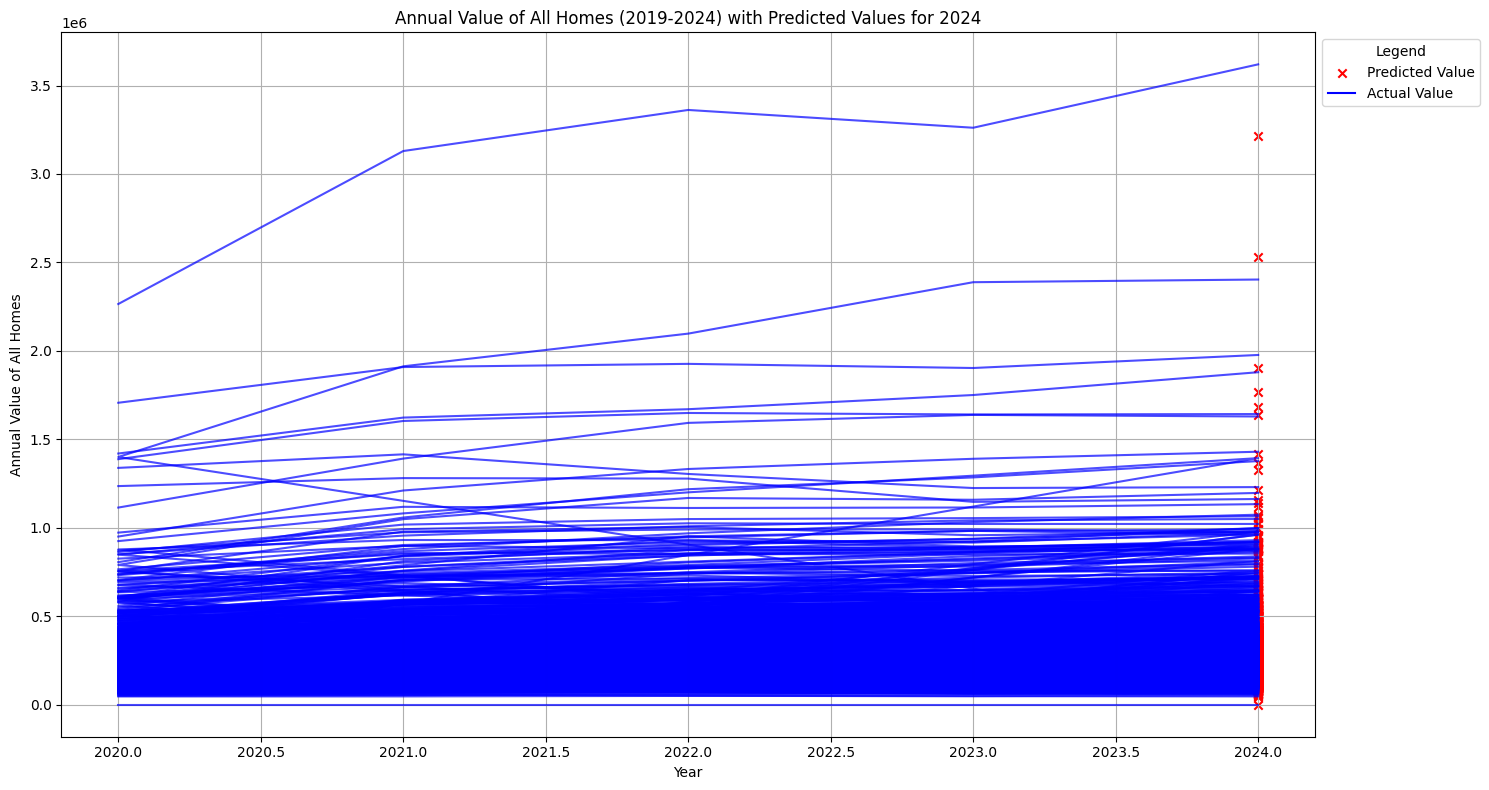

In [6]:
import matplotlib.pyplot as plt

# Merge actual values from zhvi_condo_fmt_df and predicted values from arima_predict_results_df
merged_df = zhvi_condo_fmt_df[['County', 'State', 'Year_Recorded', 'AnnualValue_AllHomes']].copy()
merged_df['Type'] = 'Actual'

# Add predicted values to the merged dataframe
arima_predict_results_df['Type'] = 'Predicted'
arima_predict_results_df.rename(columns={'Predicted_2024': 'AnnualValue_AllHomes'}, inplace=True)
arima_predict_results_df['Year_Recorded'] = 2024  # Ensure the year is set to 2024

# Concatenate the actual and predicted data
plot_df = pd.concat([merged_df, arima_predict_results_df[['County', 'State', 'Year_Recorded', 'AnnualValue_AllHomes', 'Type']]])

# Plot the data
plt.figure(figsize=(15, 8))

# Plot actual values
actual_data = plot_df[plot_df['Type'] == 'Actual']
for county in actual_data['County'].unique():
    county_data = actual_data[actual_data['County'] == county]
    plt.plot(county_data['Year_Recorded'], county_data['AnnualValue_AllHomes'], color='blue', alpha=0.7)

# Highlight predicted values with a different marker
predicted_data = plot_df[plot_df['Type'] == 'Predicted']
plt.scatter(predicted_data['Year_Recorded'], predicted_data['AnnualValue_AllHomes'], color='red', label='Predicted Value', marker='x')

# Add labels and legend
plt.title('Annual Value of All Homes (2019-2024) with Predicted Values for 2024')
plt.xlabel('Year')
plt.ylabel('Annual Value of All Homes')
plt.plot([], [], color='blue', label='Actual Value')  # Add a dummy plot for the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')
plt.grid(True)
plt.tight_layout()
plt.show()


List few records with Actual Values VS Predicted Values

In [7]:
arima_predict_results_df.head(10)

,State,County,AnnualValue_AllHomes,Actual_2024,MAE,RMSE,Type,Year_Recorded
0,AL,AUTAUGA,196200,202500,6300,6300,Predicted,2024
1,AL,BALDWIN,351800,349500,2300,2300,Predicted,2024
2,AL,BARBOUR,142200,145800,3600,3600,Predicted,2024
3,AL,BIBB,193700,198500,4800,4800,Predicted,2024
4,AL,BLOUNT,224000,229300,5300,5300,Predicted,2024
5,AL,BULLOCK,93100,98200,5100,5100,Predicted,2024
6,AL,CALHOUN,168000,172200,4200,4200,Predicted,2024
7,AL,CHAMBERS,159100,167500,8400,8400,Predicted,2024
8,AL,CHILTON,215900,219500,3600,3600,Predicted,2024
9,AL,CLAY,135900,136700,800,800,Predicted,2024


Build SARIMA model to predict House Values

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_and_evaluate_sarima_for_all(df, target_column):
    """
    Train a SARIMA model and evaluate its performance on test data (2024) for each State and County.
    Calculate the overall RMSE for the entire test set (2024).
    """
    # List to store results for all States and Counties
    results = []
    all_actuals = []  # To store all actual values
    all_predictions = []  # To store all predicted values

    # Iterate through each unique combination of State and County
    for state in df['State'].unique():
        for county in df['County'].unique():
            
            # Filter data for the specific State and County
            sarima_df = df[(df['State'] == state) & (df['County'] == county)]
            
            if sarima_df.empty:
                continue

            # Prepare data for SARIMA
            sarima_df = sarima_df[['Year_Recorded', target_column]].rename(columns={'Year_Recorded': 'ds', target_column: 'y'})
            sarima_df['ds'] = pd.to_datetime(sarima_df['ds'], format='%Y')
            sarima_df.set_index('ds', inplace=True)

            # Split data into train (2019-2023) and test (2024)
            train_data = sarima_df[sarima_df.index.year < 2024]
            test_data = sarima_df[sarima_df.index.year == 2024]

            # If there is no test data (e.g., 2024), skip this iteration
            if test_data.empty:
                continue

            # Fit SARIMA model
            model = SARIMAX(train_data['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  
            model_fit = model.fit(disp=False)


            # Forecast for 2024
            forecast = model_fit.forecast(steps=1)
            predicted_2024 = forecast[0]
            actual_2024 = test_data['y'].iloc[0]
            # Convert all numeric columns to integers

            # Calculate evaluation metrics for this State-County pair
            mae = mean_absolute_error([actual_2024], [predicted_2024])
            rmse = np.sqrt(mean_squared_error([actual_2024], [predicted_2024]))
            r2 = r2_score([actual_2024], [predicted_2024])

            # Append results for this State-County pair
            results.append({
                'State': state,
                'County': county,
                'Predicted_2024': predicted_2024,
                'Actual_2024': actual_2024,
                'MAE': mae,
                'RMSE': rmse
            })

            # Append to the lists of actual and predicted values
            all_actuals.append(actual_2024)
            all_predictions.append(predicted_2024)

    # Calculate overall RMSE for the entire test set (across all State-County pairs)
    overall_rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    
    # Print the overall RMSE for the test set
    print(f"Overall RMSE for the test set (2024): {overall_rmse:.2f}")

    # Return the detailed results for each State and County
    return pd.DataFrame(results), overall_rmse

# Example usage for 'AnnualValue_AllHomes'
sarima_predict_results_df, sarima_rmse = train_and_evaluate_sarima_for_all(zhvi_condo_fmt_df, 'AnnualValue_AllHomes')

# Display the detailed results and overall RMSE
print(f"Overall RMSE: {sarima_rmse:.2f}")


Overall RMSE for the test set (2024): 16329.37
Overall RMSE: 16329.37


In [11]:
sarima_predict_results_df = sarima_predict_results_df.astype({col: 'int' for col in sarima_predict_results_df.select_dtypes(include=['float64', 'int64']).columns})
sarima_predict_results_df.head(10)

,State,County,Predicted_2024,Actual_2024,MAE,RMSE
0,AL,AUTAUGA,194400,202500,8100,8100
1,AL,BALDWIN,345400,349500,4100,4100
2,AL,BARBOUR,142300,145800,3500,3500
3,AL,BIBB,192900,198500,5600,5600
4,AL,BLOUNT,222700,229300,6600,6600
5,AL,BULLOCK,94100,98200,4100,4100
6,AL,CALHOUN,167700,172200,4500,4500
7,AL,CHAMBERS,158700,167500,8800,8800
8,AL,CHILTON,212600,219500,6900,6900
9,AL,CLAY,136100,136700,600,600


Build Prophet Model for Timeseries build.

In [15]:
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')
def train_and_evaluate_prophet_for_all(df, target_column):
    """
    Train a Prophet model and evaluate its performance on test data (2024) for each State and County.
    Calculate the overall RMSE for the entire test set (2024).
    """
    # Preprocess the data once to avoid redundant operations
    df = df[['State', 'County', 'Year_Recorded', target_column]].rename(
        columns={'Year_Recorded': 'ds', target_column: 'y'}
    )
    df['ds'] = pd.to_datetime(df['ds'], format='%Y')

    # Split data into train (before 2024) and test (2024)
    train_data = df[df['ds'].dt.year < 2024]
    test_data = df[df['ds'].dt.year == 2024]

    # If no test data exists, return early
    if test_data.empty:
        print("No test data available for 2024.")
        return pd.DataFrame(), None

    # Group data by State and County for parallel processing
    grouped_train = train_data.groupby(['State', 'County'])
    grouped_test = test_data.groupby(['State', 'County'])

    results = []
    all_actuals = []
    all_predictions = []

    for (state, county), train_group in grouped_train:
        # Check if test data exists for this State-County pair
        if (state, county) not in grouped_test.groups:
            continue

        test_group = grouped_test.get_group((state, county))

        # Fit Prophet model
        model = Prophet()
        model.fit(train_group)

        # Create a future dataframe with the specific date for 2024
        future = pd.DataFrame({'ds': pd.to_datetime(['2024-01-01'])})

        # Forecast for the future period
        forecast = model.predict(future)

        # Extract the prediction for 2024
        predicted_2024 = forecast['yhat'].iloc[0]
        actual_2024 = test_group['y'].iloc[0]

        # Round off actual and predicted values to the nearest 100
        predicted_2024 = int(round(predicted_2024 / 100) * 100)
        actual_2024 = int(round(actual_2024 / 100) * 100)

        # Calculate evaluation metrics
        mae = int(round(mean_absolute_error([actual_2024], [predicted_2024]), -1))
        rmse = int(round(np.sqrt(mean_squared_error([actual_2024], [predicted_2024])), -1))
        r2 = r2_score([actual_2024], [predicted_2024])

        # Append results
        results.append({
            'State': state,
            'County': county,
            'Predicted_2024': predicted_2024,
            'Actual_2024': actual_2024,
            'MAE': mae,
            'RMSE': rmse
        })

        all_actuals.append(actual_2024)
        all_predictions.append(predicted_2024)

    # Calculate overall RMSE
    if all_actuals and all_predictions:
        overall_rmse = int(round(np.sqrt(mean_squared_error(all_actuals, all_predictions)), -1))
        print(f"Overall RMSE for the test set (2024): {overall_rmse}")
    else:
        overall_rmse = None
        print("No predictions were made due to lack of forecast data.")

    return pd.DataFrame(results), overall_rmse

# Example usage
prophet_predict_results_df, prophet_rmse = train_and_evaluate_prophet_for_all(zhvi_condo_fmt_df, 'AnnualValue_AllHomes')

# Display the detailed results and overall RMSE
if prophet_rmse is not None:
    print(f"Overall RMSE: {prophet_rmse}")
else:
    print("No RMSE calculated due to lack of forecast data.")


20:11:23 - cmdstanpy - INFO - Chain [1] start processing
20:11:23 - cmdstanpy - INFO - Chain [1] done processing
20:11:23 - cmdstanpy - INFO - Chain [1] start processing
20:11:24 - cmdstanpy - INFO - Chain [1] done processing
20:11:24 - cmdstanpy - INFO - Chain [1] start processing
20:11:24 - cmdstanpy - INFO - Chain [1] done processing
20:11:24 - cmdstanpy - INFO - Chain [1] start processing
20:11:25 - cmdstanpy - INFO - Chain [1] done processing
20:11:25 - cmdstanpy - INFO - Chain [1] start processing
20:11:25 - cmdstanpy - INFO - Chain [1] done processing
20:11:25 - cmdstanpy - INFO - Chain [1] start processing
20:11:25 - cmdstanpy - INFO - Chain [1] done processing
20:11:25 - cmdstanpy - INFO - Chain [1] start processing
20:11:26 - cmdstanpy - INFO - Chain [1] done processing
20:11:26 - cmdstanpy - INFO - Chain [1] start processing
20:11:26 - cmdstanpy - INFO - Chain [1] done processing
20:11:26 - cmdstanpy - INFO - Chain [1] start processing
20:11:26 - cmdstanpy - INFO - Chain [1]

Overall RMSE for the test set (2024): 17940
Overall RMSE: 17940


In [16]:
prophet_predict_results_df = prophet_predict_results_df.astype({col: 'int' for col in prophet_predict_results_df.select_dtypes(include=['float64', 'int64']).columns})
prophet_predict_results_df.head(10)

,State,County,Predicted_2024,Actual_2024,MAE,RMSE
0,AL,AUTAUGA,192700,202500,9800,9800
1,AL,BALDWIN,347900,349500,1600,1600
2,AL,BARBOUR,138300,145800,7500,7500
3,AL,BIBB,183700,198500,14800,14800
4,AL,BLOUNT,225500,229300,3800,3800
5,AL,BULLOCK,91900,98200,6300,6300
6,AL,CALHOUN,163500,172200,8700,8700
7,AL,CHAMBERS,163400,167500,4100,4100
8,AL,CHILTON,216700,219500,2800,2800
9,AL,CLAY,140300,136700,3600,3600


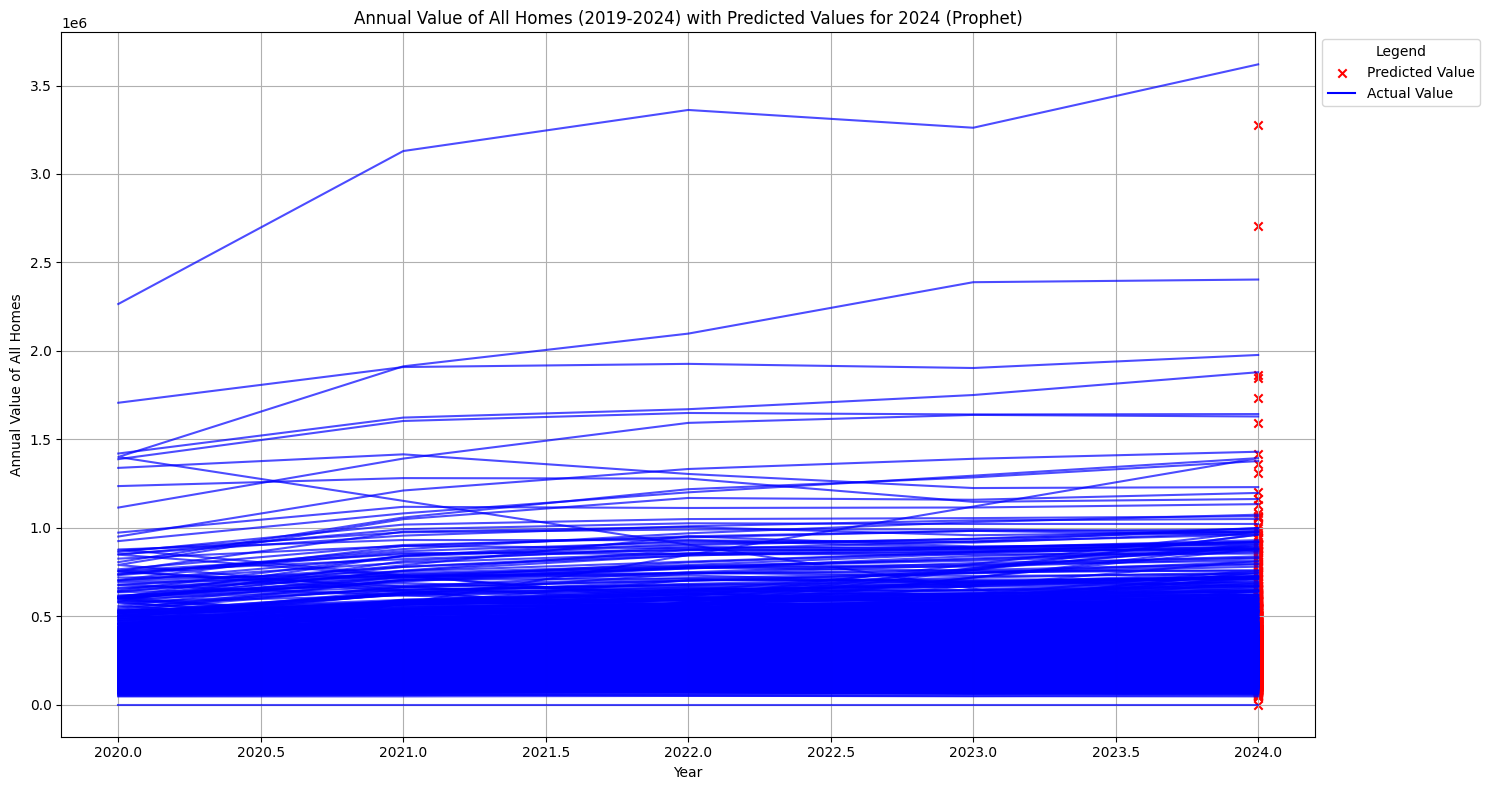

In [17]:
import matplotlib.pyplot as plt

# Merge actual values from `actual_data` and predicted values from `prophet_predict_results_df`
merged_prophet_df = actual_data.copy()
merged_prophet_df['Type'] = 'Actual'

# Add predicted values to the merged dataframe
prophet_predict_results_df['Type'] = 'Predicted'
prophet_predict_results_df.rename(columns={'Predicted_2024': 'AnnualValue_AllHomes'}, inplace=True)
prophet_predict_results_df['Year_Recorded'] = 2024  # Ensure the year is set to 2024

# Concatenate the actual and predicted data
plot_prophet_df = pd.concat([merged_prophet_df, prophet_predict_results_df[['County', 'State', 'Year_Recorded', 'AnnualValue_AllHomes', 'Type']]])

# Plot the data
plt.figure(figsize=(15, 8))

# Plot actual values
actual_data = plot_prophet_df[plot_prophet_df['Type'] == 'Actual']
for county in actual_data['County'].unique():
    county_data = actual_data[actual_data['County'] == county]
    plt.plot(county_data['Year_Recorded'], county_data['AnnualValue_AllHomes'], color='blue', alpha=0.7)

# Highlight predicted values with a different marker
predicted_data = plot_prophet_df[plot_prophet_df['Type'] == 'Predicted']
plt.scatter(predicted_data['Year_Recorded'], predicted_data['AnnualValue_AllHomes'], color='red', label='Predicted Value', marker='x')

# Add labels and legend
plt.title('Annual Value of All Homes (2019-2024) with Predicted Values for 2024 (Prophet)')
plt.xlabel('Year')
plt.ylabel('Annual Value of All Homes')
plt.plot([], [], color='blue', label='Actual Value')  # Add a dummy plot for the legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')
plt.grid(True)
plt.tight_layout()
plt.show()